In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaModel, RobertaTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

/home/deepak/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ISEAR_CSV = "./datasets_csv/ISEAR_dataset.csv"
CLASS_LABELS = ['Anger', 'Fear', 'Joy', 'Sadness']
ROBERTA_CONFIG = "roberta-base"
MAX_LEN = 256
BATCH_SIZE = 32
NUM_CLASSES = 4
LEARNING_RATE = 2e-6
EPOCHS = 12

In [ ]:
class ClassificationModule(nn.Module):
    def __init__(self, number_of_classes, dropout_val):
        super(ClassificationModule, self).__init__()
        self.dense1 = nn.Linear(in_features=4960, out_features=128)
        self.dropout = nn.Dropout(p=0.2)
        self.classification_output = nn.Linear(in_features=128, out_features=number_of_classes)

    def forward(self, tri_channel_output):
        dense1_output = F.relu(self.dense1(tri_channel_output))                                 # shape (BS, 128)
        dropout_output = self.dropout(dense1_output)                                            # shape (BS, 128)
        classification_output = F.softmax(self.classification_output(dropout_output), dim=1)    # shape (BS, 4)
        return classification_output


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_shape):
        super(AttentionLayer, self).__init__()
        self.W = nn.Parameter(torch.randn(input_shape[-1], 1))
        self.b = nn.Parameter(torch.zeros(input_shape[1], 1))

    def forward(self, x):
        e = torch.tanh(torch.matmul(x, self.W) + self.b)
        a = F.softmax(e, dim=1)
        output = x * a
        return torch.sum(output, dim=1)

In [ ]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, dff):
        super(FeedForwardNetwork, self).__init__()
        self.ffn = nn.Sequential(
            nn.Linear(in_features=d_model, out_features=dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, epsilon=1e-6, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads)
        self.ffn = FeedForwardNetwork(d_model, dff)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)

    def forward(self, x, mask=None):
        mha_output, _ = self.mha(x, x, x, attn_mask=mask)
        dropout1_output = self.dropout1(mha_output)
        output1 = self.layernorm1(x + dropout1_output)

        ffn_output = self.ffn(output1)
        dropout2_output = self.dropout2(ffn_output)
        output2 = self.layernorm2(output1 + dropout2_output)

        return output2

In [ ]:
class GatingLayer(nn.Module):
    def __init__(self, input_size):
        super(GatingLayer, self).__init__()
        self.gate = nn.Linear(in_features=input_size, out_features=input_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        gate_value = self.sigmoid(self.gate(x))
        return x * gate_value

In [ ]:
class TriChannelModule(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, dropout_val):
        super(TriChannelModule,self).__init__()

        self.channel1_conv = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.channel1_maxpool = nn.MaxPool1d(kernel_size=2)
        self.channel1_flatten = nn.Flatten()
        self.channel1_gating = GatingLayer(input_size=4064)

        self.channel2_bilstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.channel2_attention_layer = AttentionLayer(input_shape=(BATCH_SIZE, MAX_LEN, lstm_hidden_size*2))
        self.channel2_gating = GatingLayer(input_size=lstm_hidden_size*2)

        self.transformer_encoder = TransformerEncoderLayer(d_model=input_size, num_heads=1, dff=512)
        self.channel3_attention_layer = AttentionLayer(input_shape=(BATCH_SIZE, MAX_LEN, input_size))
        self.channel3_gating=GatingLayer(input_size=input_size)

    def forward(self, roberta_embeddings):

        # Pipeline A: CNN for Local Feature Extraction
        roberta_embeddings = roberta_embeddings.permute(0, 2, 1)                                                            # shape (BS, 768, 256)
        channel1_conv_output = self.channel1_conv(roberta_embeddings)                                                       # shape (BS, 32, 254)
        channel1_max_pool_output = self.channel1_maxpool(channel1_conv_output)                                              # shape (BS, 32, 127)
        channel1_flatten_output=self.channel1_flatten(channel1_max_pool_output)                                             # shape (BS, 4064)
        channel1_gating_output = self.channel1_gating(channel1_flatten_output)                                              # shape (BS, 4064)

        # Pipeline B: BiLSTM with Attention for Sequential Context
        roberta_embeddings = roberta_embeddings.permute(0, 2, 1)                                                            # shape (BS, 256, 768)
        channel2_bilstm_output, _ = self.channel2_bilstm(roberta_embeddings)                                                # shape (BS, 256, 128)
        channel2_bilstm_attention_output = self.channel2_attention_layer(channel2_bilstm_output)                            # shape (BS, 128)
        channel2_gating_output = self.channel2_gating(channel2_bilstm_attention_output)                                     # shape (BS, 128)

        # Pipeline C: Transformer Encoder for Contextual Word Representations
        channel3_transformer_block_output = self.transformer_encoder(roberta_embeddings)                                    # shape (BS, 256, 768)
        channel3_transformer_attention_output = self.channel3_attention_layer(channel3_transformer_block_output)            # shape (BS, 768)
        channel3_gating_output = self.channel3_gating(channel3_transformer_attention_output)                                # shape (BS, 768)

        tri_channel_output = torch.cat((channel1_gating_output, channel2_gating_output, channel3_gating_output), dim=1)     # shape (BS, 4960)
        return tri_channel_output


In [ ]:
class TER(nn.Module):
    def __init__(self, number_of_classes, lstm_hidden_size=64, dropout_val=0.1):
        super(TER, self).__init__()
        self.roberta = RobertaModel.from_pretrained(ROBERTA_CONFIG)
        self.tri_channel = TriChannelModule(input_size=self.roberta.config.hidden_size, lstm_hidden_size=lstm_hidden_size, dropout_val=dropout_val)
        self.classifier = ClassificationModule(number_of_classes=number_of_classes, dropout_val=dropout_val)

    def forward(self, input_seq, attention_mask):
        roberta_pooled_output = self.roberta(input_seq, attention_mask=attention_mask)[0]   # shape (BS, 256, 768)
        tri_channel_output = self.tri_channel(roberta_pooled_output)                        # shape (BS, 4960)
        classification_output = self.classifier(tri_channel_output)                         # shape (BS, 4)
        return classification_output

In [ ]:
def tokenize_sentences(sentences, tokenizer, max_length):
    tokenized_sequences = tokenizer(sentences, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return tokenized_sequences['input_ids'], tokenized_sequences['attention_mask']

In [ ]:
ISEAR_dataset = pd.read_csv(ISEAR_CSV, index_col=0)
ISEAR_dataset

,ISEAR_labels,ISEAR_sentences
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,joy,When I got a letter offering me the Summer job...
...,...,...
4376,sadness,This issue worried me rather than saddening me...
4377,joy,I received a letter from a distant friend.
4378,fear,My parents were out and I was the eldest at ho...
4379,anger,Two years back someone invited me to be the tu...


In [ ]:
ISEAR_dataset['ISEAR_labels'].value_counts()

ISEAR_labels
sadness    1096
anger      1096
fear       1095
joy        1094
Name: count, dtype: int64

In [ ]:
ISEAR_train_data, ISEAR_val_data = train_test_split(ISEAR_dataset, test_size=0.1, random_state=42)
ISEAR_X_train = list(ISEAR_train_data['ISEAR_sentences'])
ISEAR_X_val = list(ISEAR_val_data['ISEAR_sentences'])
ISEAR_Y_train = list(ISEAR_train_data['ISEAR_labels'])
ISEAR_Y_val = list(ISEAR_val_data['ISEAR_labels'])

In [ ]:
# Initialize XLM-RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_CONFIG)

In [ ]:
train_input_ids, train_attention_mask = tokenize_sentences(ISEAR_X_train, tokenizer, max_length=MAX_LEN)
val_input_ids, val_attention_mask = tokenize_sentences(ISEAR_X_val, tokenizer, max_length=MAX_LEN)

In [ ]:
label_encoder = preprocessing.LabelEncoder()
ISEAR_Y_train_encoded = label_encoder.fit_transform(ISEAR_Y_train)
ISEAR_Y_val_encoded = label_encoder.fit_transform(ISEAR_Y_val)

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}

In [ ]:
# Convert labels to PyTorch tensors
train_labels = torch.tensor(ISEAR_Y_train_encoded, dtype=torch.int64)
val_labels = torch.tensor(ISEAR_Y_val_encoded, dtype=torch.int64)

In [ ]:
# Creating Dataloaders
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Initializing the model
model = TER(number_of_classes=NUM_CLASSES)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

TER(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [ ]:
# Training the model
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (input_seq, attention_mask, labels) in enumerate(train_loader):
        input_seq = input_seq.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(input_seq, attention_mask)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 50 == 49:
            print(f"Epoch [{epoch + 1}/{EPOCHS}] "
                  f"Batch [{batch_idx + 1}/{len(train_loader)}] "
                  f"Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

Epoch [1/12] Batch [50/124] Loss: 0.6928
Epoch [1/12] Batch [100/124] Loss: 0.6917
Epoch [2/12] Batch [50/124] Loss: 0.6565
Epoch [2/12] Batch [100/124] Loss: 0.5497
Epoch [3/12] Batch [50/124] Loss: 0.4773
Epoch [3/12] Batch [100/124] Loss: 0.4627
Epoch [4/12] Batch [50/124] Loss: 0.4475
Epoch [4/12] Batch [100/124] Loss: 0.4502
Epoch [5/12] Batch [50/124] Loss: 0.4379
Epoch [5/12] Batch [100/124] Loss: 0.4399
Epoch [6/12] Batch [50/124] Loss: 0.4353
Epoch [6/12] Batch [100/124] Loss: 0.4384
Epoch [7/12] Batch [50/124] Loss: 0.4286
Epoch [7/12] Batch [100/124] Loss: 0.4333
Epoch [8/12] Batch [50/124] Loss: 0.4199
Epoch [8/12] Batch [100/124] Loss: 0.4299
Epoch [9/12] Batch [50/124] Loss: 0.4241
Epoch [9/12] Batch [100/124] Loss: 0.4220
Epoch [10/12] Batch [50/124] Loss: 0.4208
Epoch [10/12] Batch [100/124] Loss: 0.4208
Epoch [11/12] Batch [50/124] Loss: 0.4205
Epoch [11/12] Batch [100/124] Loss: 0.4182
Epoch [12/12] Batch [50/124] Loss: 0.4195
Epoch [12/12] Batch [100/124] Loss: 0.419

In [ ]:
# Evaluating the model
model.eval()
total_correct = 0
total_samples = 0

predicted_labels = []
true_labels = []

with torch.no_grad():
    for input_seq, attention_mask, labels in val_loader:
        input_seq = input_seq.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        output = model(input_seq, attention_mask)
        _, predicted = torch.max(output, 1)

        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = total_correct / total_samples
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Validation Accuracy: 87.02%
F1-score: 0.8693
Precision: 0.8726
Recall: 0.8702


In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize="true")

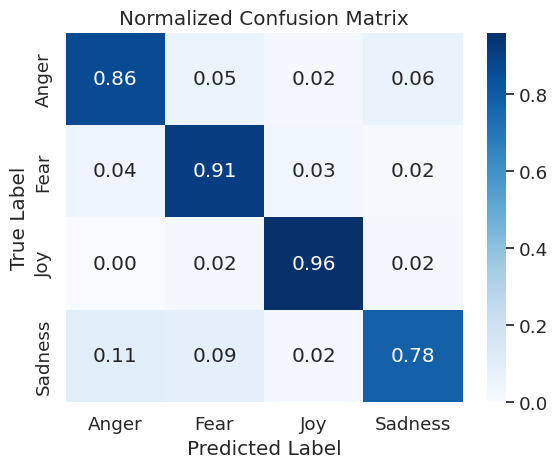

In [ ]:
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=True, xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('Confusion Matrix.png')
plt.show()

In [ ]:
# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=CLASS_LABELS, output_dict=True)

print("{:<15} {:<15} {:<15} {:<15}".format("Class", "F1-Score", "Precision", "Recall"))
print("========================================================")
for class_label, metrics in report.items():
    if class_label in CLASS_LABELS:
        print("{:<15} {:<15.4f} {:<15.4f} {:<15.4f}".format(class_label, metrics['f1-score'], metrics['precision'], metrics['recall']))

print("\nOverall Accuracy: {:.4f}".format(report['accuracy']))

Class           F1-Score        Precision       Recall         
Anger           0.8351          0.8100          0.8617         
Fear            0.8750          0.8468          0.9052         
Joy             0.9360          0.9135          0.9596         
Sadness         0.8382          0.9099          0.7769         

Overall Accuracy: 0.8702
